# Model Training
---

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import sys
sys.path.append('../scripts')
from data_utils import labels, view_img, calculate_featuremap_size, maxpool2d_size

import warnings
warnings.filterwarnings("ignore")

In [21]:
# import data

# CNN data
test_cnn_X = pd.read_csv('../data/labels/test_cnn_X.csv', index_col=0)
test_cnn_y = pd.read_csv('../data/labels/test_cnn_y.csv', index_col=0)

train_cnn_X = pd.read_csv('../data/labels/train_cnn_X.csv', index_col=0)
train_cnn_y = pd.read_csv('../data/labels/train_cnn_y.csv', index_col=0)

val_cnn_X = pd.read_csv('../data/labels/val_cnn_X.csv', index_col=0)
val_cnn_y = pd.read_csv('../data/labels/val_cnn_y.csv', index_col=0)


# Tabular data
test_tab_X = pd.read_csv('../data/labels/test_tab_X.csv', index_col=0)
test_tab_y = pd.read_csv('../data/labels/test_tab_y.csv', index_col=0)

train_tab_X = pd.read_csv('../data/labels/train_tab_X.csv', index_col=0)
train_tab_y = pd.read_csv('../data/labels/train_tab_y.csv', index_col=0)

val_tab_X = pd.read_csv('../data/labels/val_tab_X.csv', index_col=0)
val_tab_y = pd.read_csv('../data/labels/val_tab_y.csv', index_col=0)

# MLP Model

In [22]:
# Convert data to torch.float32

def convert_to_float32(data):
    return torch.tensor(data.values, dtype=torch.float32)

# Convert Tabular data
test_tab_X = convert_to_float32(test_tab_X)
test_tab_y = convert_to_float32(test_tab_y)

train_tab_X = convert_to_float32(train_tab_X)
train_tab_y = convert_to_float32(train_tab_y)

val_tab_X = convert_to_float32(val_tab_X)
val_tab_y = convert_to_float32(val_tab_y)

In [23]:
# Developed a multi-label classification multi-lablel perceptron for tabular data

class MLP(nn.Module):
    def __init__(self, in_features=4, hidden1=64, hidden2=32, out_features=15):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=in_features, out_features=hidden1)

        self.fc2 = nn.Linear(in_features=hidden1, out_features=hidden2)

        self.output = nn.Linear(in_features=hidden2, out_features=out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        
        return x

model = MLP()

In [24]:
# Identified label imbalance among target variables

label_counts = train_tab_y.sum(dim=0)
print(label_counts)

tensor([ 547.,  141.,  230.,  103.,  560.,  118.,   97.,    7., 1039.,  268.,
        4047.,  371.,  153.,   63.,  192.])


In [25]:
# Select loss function and optimizer

num_samples = train_tab_y.shape[0]
neg_counts = num_samples - label_counts
pos_weight = neg_counts / (label_counts + 1e-8)  


criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [26]:
# Model training

epoch = 100
losses = []

for i in range(epoch):

    y_pred = model(train_tab_X)

    loss = criterion(y_pred, train_tab_y)

    losses.append(loss.detach().numpy())

    if i % 10 == 0:
        print(f'Epoch: {i}, loss: {loss}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


Epoch: 0, loss: 1.280409574508667
Epoch: 10, loss: 1.2148271799087524
Epoch: 20, loss: 1.1576284170150757
Epoch: 30, loss: 1.1291695833206177
Epoch: 40, loss: 1.1463675498962402
Epoch: 50, loss: 1.136458158493042
Epoch: 60, loss: 1.1094815731048584
Epoch: 70, loss: 1.0876004695892334
Epoch: 80, loss: 1.0721031427383423
Epoch: 90, loss: 1.0618703365325928


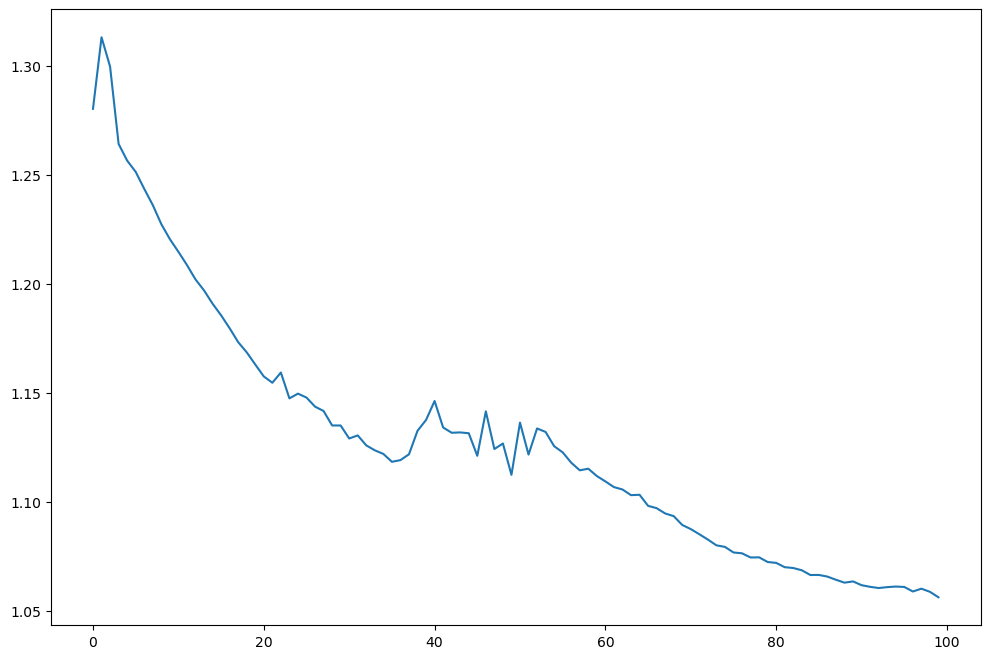

In [27]:
plt.figure(figsize=(12,8))
plt.plot(range(epoch), losses)
plt.show()

# Custom CNN Model

In [28]:

# images need to be converted to float32, issue: current X represent file path to images not images themselves
# use ToTensor dugin transformation
""" 
# Convert CNN data
test_cnn_X = convert_to_float32(test_cnn_X)
test_cnn_y = convert_to_float32(test_cnn_y)

train_cnn_X = convert_to_float32(train_cnn_X)
train_cnn_y = convert_to_float32(train_cnn_y)

val_cnn_X = convert_to_float32(val_cnn_X)
val_cnn_y = convert_to_float32(val_cnn_y)
"""



' \n# Convert CNN data\ntest_cnn_X = convert_to_float32(test_cnn_X)\ntest_cnn_y = convert_to_float32(test_cnn_y)\n\ntrain_cnn_X = convert_to_float32(train_cnn_X)\ntrain_cnn_y = convert_to_float32(train_cnn_y)\n\nval_cnn_X = convert_to_float32(val_cnn_X)\nval_cnn_y = convert_to_float32(val_cnn_y)\n'

In [29]:
# Convert labels to float32
"""
test_cnn_y = convert_to_float32(test_cnn_y)
train_cnn_y = convert_to_float32(train_cnn_y)
val_cnn_y = convert_to_float32(val_cnn_y)
"""

'\ntest_cnn_y = convert_to_float32(test_cnn_y)\ntrain_cnn_y = convert_to_float32(train_cnn_y)\nval_cnn_y = convert_to_float32(val_cnn_y)\n'

In [30]:
# Initialize CNN Dataset and DataLoader

class CNNDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, idx):
        img_path = self.X.iloc[idx]["image_path"]
        img = Image.open(img_path).convert('L')
        label = torch.tensor(self.y.iloc[idx].values, dtype=torch.float32)

        if self.transform:
            img = self.transform(img)

        return img, label
    
# Apply transformations: convert to tensor, resize to 224x224
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

# Initialize datasets
test_dataset = CNNDataset(X=test_cnn_X, y=test_cnn_y, transform=transform)
train_dataset = CNNDataset(X=train_cnn_X, y=train_cnn_y, transform=transform)
val_dataset = CNNDataset(X=val_cnn_X, y=val_cnn_y, transform=transform)

# Initialize loaders
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)

In [31]:
calculate_featuremap_size(128, 0, 1, 3)

126

In [32]:
maxpool2d_size(12, 0, 2, 2)

6

In [33]:
# shape (128,128) # change dataset transform shape to (128, 128) to test

"""
class CNN(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3) # 64 x 126 x 126
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2,2) # 64 x 63 x 63

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3) # 32 x 61 x 61
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2,2) # 32 x 30 x 30

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3) # 16 x 28 x 28
        self.bn3 = nn.BatchNorm2d(16)
        self.pool3 = nn.MaxPool2d(2,2) # 16 x 14 x 14

        self.fc1 = nn.Linear(in_features= 16 * 14 * 14, out_features=32)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=32, out_features=15)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN()
"""

'\nclass CNN(nn.Module):\n\n    def __init__(self):\n        super().__init__()\n\n        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3) # 64 x 126 x 126\n        self.bn1 = nn.BatchNorm2d(64)\n        self.pool1 = nn.MaxPool2d(2,2) # 64 x 63 x 63\n\n        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3) # 32 x 61 x 61\n        self.bn2 = nn.BatchNorm2d(32)\n        self.pool2 = nn.MaxPool2d(2,2) # 32 x 30 x 30\n\n        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3) # 16 x 28 x 28\n        self.bn3 = nn.BatchNorm2d(16)\n        self.pool3 = nn.MaxPool2d(2,2) # 16 x 14 x 14\n\n        self.fc1 = nn.Linear(in_features= 16 * 14 * 14, out_features=32)\n        self.dropout = nn.Dropout(0.5)\n        self.fc2 = nn.Linear(in_features=32, out_features=15)\n\n    def forward(self, x):\n        x = self.pool1(F.relu(self.bn1(self.conv1(x))))\n        x = self.pool2(F.relu(self.bn2(self.conv2(x))))\n        x = self.pool3(

In [34]:
# Create CNN architecture

# shape (64,64)
class CNN(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3) # 64 x 62 x62
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2,2) # 64 x 31 x 31

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3) # 32 x 29 x 29
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2,2) # 32 x 14 x 14

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3) # 16 x 12 x 12
        self.bn3 = nn.BatchNorm2d(16)
        self.pool3 = nn.MaxPool2d(2,2) # 16 x 6 x 6

        self.fc1 = nn.Linear(in_features= 16 * 6 * 6, out_features=32)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=32, out_features=15)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN()

In [ ]:
# Check device components

print("PyTorch CUDA version:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

PyTorch CUDA version: 11.8
CUDA available: True
Device count: 1
Device name: NVIDIA GeForce RTX 3070


In [ ]:
# Identified imbalance label classes
train_cnn_y.sum().values

array([ 547,  141,  230,  103,  560,  118,   97,    7, 1039,  268, 4047,
        371,  153,   63,  192], dtype=int64)

In [ ]:
# Set device and prepare BCEWithLogitLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

label_counts = train_cnn_y.sum().values
total_samples = train_cnn_y.shape[0]

# Calculate pos_weight for BCEWithLogitLoss to account for label imbalance
pos_weight = (total_samples - label_counts) / label_counts
pos_weight = torch.tensor(pos_weight, dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Set optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)
model = model.to(device)
print(device)

cuda


In [38]:
# Model Training


num_epoch = 1

for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0

    for i, (imgs, labels) in enumerate(train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device).float()
        
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epoch}], Batch: {i+1}, Loss: {loss.item():.4f}')



avg_loss = running_loss / len(train_loader)
print(f"Epoch [{epoch+1}/{num_epoch}] Completed. Average Loss: {avg_loss:.4f}")



Epoch [1/1], Batch: 1, Loss: 1.6481
Epoch [1/1], Batch: 11, Loss: 1.1199
Epoch [1/1], Batch: 21, Loss: 1.1550
Epoch [1/1], Batch: 31, Loss: 1.1030
Epoch [1/1], Batch: 41, Loss: 1.0436
Epoch [1/1], Batch: 51, Loss: 1.1941
Epoch [1/1], Batch: 61, Loss: 1.1140
Epoch [1/1], Batch: 71, Loss: 0.9705
Epoch [1/1], Batch: 81, Loss: 1.0940
Epoch [1/1], Batch: 91, Loss: 1.2852
Epoch [1/1], Batch: 101, Loss: 1.1307
Epoch [1/1] Completed. Average Loss: 1.2863


In [ ]:
# Validation Loop

# ResNet Model (Testing)

In [42]:
import torchvision.models as models

num_labels = 15

model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, num_labels)

def forward_pass(imgs, labels):
    imgs = imgs.to(device)
    labels = labels.to(device).float()
    
    outputs = model(imgs)  # raw logits, shape: (batch_size, num_labels)
    
    loss = criterion(outputs, labels)
    return loss, outputs

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [46]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(imgs)  # raw logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}")

Epoch [1/10], Train Loss: 1.4507
Epoch [2/10], Train Loss: 1.4495
Epoch [3/10], Train Loss: 1.4468
Epoch [4/10], Train Loss: 1.4447
Epoch [5/10], Train Loss: 1.4514
Epoch [6/10], Train Loss: 1.4584
Epoch [7/10], Train Loss: 1.4594
Epoch [8/10], Train Loss: 1.4501


KeyboardInterrupt: 

# DenseNet Model